In [4]:
import os
import keras
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import  Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, LearningRateScheduler
from random import shuffle
import math
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.models import load_model

In [19]:
PathSpectogramFolder='out'
OutputPath='model/3/path'
OutputPathModels='model/3/'
interictalSpectograms=[]
preictalSpectograms=[]  #This array contains syntetic data, it's created to have a balance dataset and it's used for training
preictalRealSpectograms=[]  #This array containt the real preictal data, it's used for testing
#patients = ["01"]
patients = ["01","02","03","05","09"]
nSeizure=0

In [20]:
def loadSpectogramData(indexPat):
    global interictalSpectograms
    global preictalSpectograms
    global preictalRealSpectograms
    global nSeizure
    f = open(PathSpectogramFolder+'/paz'+patients[indexPat]+'/legendAllData.txt', 'r')
    line=f.readline()
    while(not "SEIZURE" in line):
        line=f.readline()
    nSeizure=nSeizure+int(line.split(":")[1].strip())
    line=f.readline()
    line=f.readline()#legge il numero di spectogrammi. non lo salvo dato che non mi serve
    nSpectograms=int(line.strip())
    nFileForSeizure=math.ceil(math.ceil(nSpectograms/50)/nSeizure)
    line=f.readline()#leggo il percorso del primo file
    
    #Lettura path files Interictal
    cont=-1
    indFilePathRead=0
    while("npy" in line and indFilePathRead<nSeizure*nFileForSeizure):
        if(indFilePathRead%nFileForSeizure==0):
            interictalSpectograms.append([])
            cont=cont+1
            interictalSpectograms[cont].append(line.split(' ')[2].rstrip())#.rstrip() remove \n
            indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                interictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
    line=f.readline()#leggo PREICTAL
    line=f.readline()#leggo n° spectogram
    line=f.readline()#leggo n°seizure(SEIZURE X)

    #Lettura path files Preictal
    cont=-1
    indFilePathRead=0   
    #while(line and indFilePathRead<nSeizure*nFileForSeizure):    
    while(line.strip()!=""):
        if("SEIZURE" in line):
            line=f.readline()#ho letto n°seizure(SEIZURE X) perciò scorro in avanti
            if(len(line.split(' '))>=3):
                preictalSpectograms.append([])
                cont=cont+1
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
                indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
        
    line=f.readline()#leggo REAL_PREICTAL
    line=f.readline()#leggo n° spectogram
    line=f.readline()#leggo n°seizure(SEIZURE X)

    #Lettura path files Real Preictal
    cont=-1
    while(line):
        if("SEIZURE" in line):
            line=f.readline()#ho letto n°seizure(SEIZURE X) perciò scorro in avanti
            preictalRealSpectograms.append([])
            cont=cont+1
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
        else:
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
            
        line=f.readline()
    f.close()

In [31]:
def createModel():

    model = Sequential()

    model.add(Conv2D(64, (2, 4), activation='relu', input_shape=(22, 59, 114)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.35))

    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Flatten())
    model.add(Dropout(0.15))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(2, activation='softmax'))

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='sen')])
        
    return model

In [33]:
def createModel3():
    model = Sequential()

    # C1
    model.add(Conv2D(16, (4, 4), strides=(1, 2), padding='same', activation='relu', input_shape=(22, 59, 114)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # C2
    model.add(Conv2D(32, (3, 3), strides=(1, 2), padding='same', activation='relu', input_shape=(22, 59, 114)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # C3
    model.add(Conv2D(64, (3, 1), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # C4
    model.add(Conv2D(128, (3, 1), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='sen')])
    
    return model

In [34]:
def createModel2():

   model = Sequential()

   # C1
   model.add(Conv2D(32, (3, 3), strides=(1, 2), padding='same', activation='relu', input_shape=(22, 59, 114)))
   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(BatchNormalization())

   # C2
   model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(BatchNormalization())

   # C3
   model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(BatchNormalization())

   model.add(Flatten())
   model.add(Dropout(0.5))
   model.add(Dense(256, activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(2, activation='softmax'))
   
   optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
   model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='sen')])
    
   return model


In [36]:
def createModel1():

    model = Sequential()
    #C1
    model.add(Conv2D(32, (5, 5), strides=(1, 2), padding='valid', activation='relu', input_shape=(22, 59, 114)))
    model.add(MaxPooling2D(pool_size=(1, 2), padding='same'))
    BatchNormalization()
    
    #C2
    model.add(Conv2D(64, (1, 3), strides=(1,1), padding='valid', activation='relu'))#incertezza se togliere padding
    model.add(MaxPooling2D(pool_size=(1, 2)))
    BatchNormalization()
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='softmax'))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='sen')])
    
    return model

In [23]:
def getFilesPathWithoutSeizure(indexSeizure):
    filesPath=[]
    for i in range(0, nSeizure):
        if(i!=indexSeizure):
            filesPath.extend(interictalSpectograms[i])
            filesPath.extend(preictalSpectograms[i])
    shuffle(filesPath)
    return filesPath

In [25]:
def generate_arrays_for_training(paths, start=0, end=100):
    while True:
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            x=x[0]
            if('P' in f):
                y = np.repeat([[0,1]], x.shape[0], axis=0)
            else:
                y = np.repeat([[1,0]], x.shape[0], axis=0)
            yield(x,y)

In [27]:
def generate_arrays_for_predict(indexPat, paths, start=0, end=100):
    while True:
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            x=x[0]
            yield(x)

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=100)

START
Parameters loaded
Patient 01
Spectograms data loaded
SEIZURE OUT: 1
Training start
Epoch 1/60
45/45 - 9s - loss: 0.9249 - accuracy: 0.6667 - sen: 0.6667 - val_loss: 0.5911 - val_accuracy: 0.6667 - val_sen: 0.6667 - lr: 0.0010 - 9s/epoch - 208ms/step
Epoch 2/60
45/45 - 7s - loss: 0.4621 - accuracy: 0.8000 - sen: 0.8000 - val_loss: 0.4165 - val_accuracy: 0.7333 - val_sen: 0.7333 - lr: 0.0010 - 7s/epoch - 152ms/step
Epoch 3/60
45/45 - 7s - loss: 0.1789 - accuracy: 0.9111 - sen: 0.9111 - val_loss: 0.2321 - val_accuracy: 0.9333 - val_sen: 0.9333 - lr: 0.0010 - 7s/epoch - 151ms/step
Epoch 4/60
45/45 - 7s - loss: 1.7561e-04 - accuracy: 1.0000 - sen: 1.0000 - val_loss: 0.2563 - val_accuracy: 0.9333 - val_sen: 0.9333 - lr: 0.0010 - 7s/epoch - 152ms/step
Epoch 5/60
45/45 - 7s - loss: 5.4880e-04 - accuracy: 1.0000 - sen: 1.0000 - val_loss: 0.2544 - val_accuracy: 0.8667 - val_sen: 0.8667 - lr: 0.0010 - 7s/epoch - 154ms/step
Epoch 6/60
45/45 - 7s - loss: 0.0056 - accuracy: 1.0000 - sen: 1.000

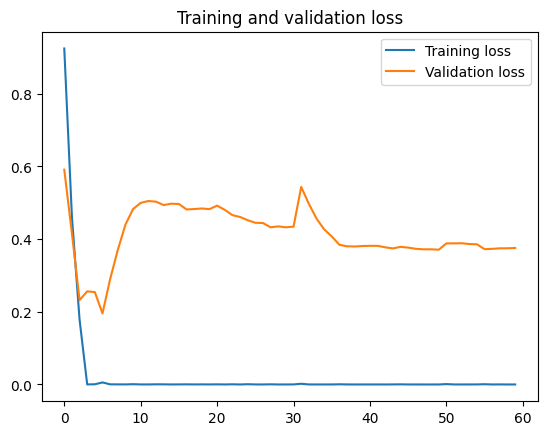

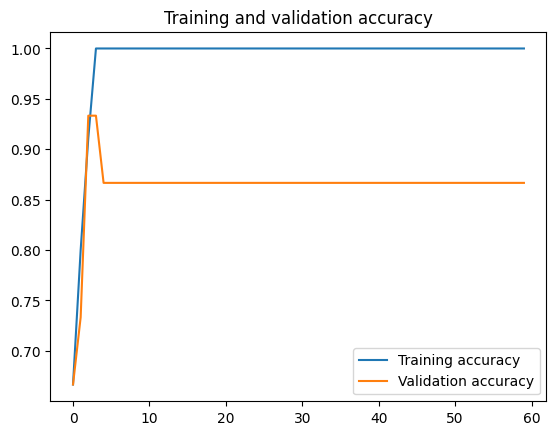

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 21, 56, 64)        58432     
                                                                 
 batch_normalization_30 (Bat  (None, 21, 56, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 21, 28, 64)       0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 21, 28, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 20, 27, 32)        8224      
                                                                 
 batch_normalization_31 (Bat  (None, 20, 27, 32)     

Epoch 1/60
45/45 - 8s - loss: 0.9709 - accuracy: 0.6889 - sen: 0.6889 - val_loss: 1.0119 - val_accuracy: 0.4667 - val_sen: 0.4667 - lr: 0.0010 - 8s/epoch - 179ms/step
Epoch 2/60
45/45 - 7s - loss: 0.4020 - accuracy: 0.8889 - sen: 0.8889 - val_loss: 1.0985 - val_accuracy: 0.4667 - val_sen: 0.4667 - lr: 0.0010 - 7s/epoch - 149ms/step
Epoch 3/60
45/45 - 7s - loss: 0.4024 - accuracy: 0.8889 - sen: 0.8889 - val_loss: 0.8436 - val_accuracy: 0.4000 - val_sen: 0.4000 - lr: 0.0010 - 7s/epoch - 148ms/step
Epoch 4/60
45/45 - 7s - loss: 0.1845 - accuracy: 0.9556 - sen: 0.9556 - val_loss: 0.9102 - val_accuracy: 0.6667 - val_sen: 0.6667 - lr: 0.0010 - 7s/epoch - 154ms/step
Epoch 5/60
45/45 - 7s - loss: 0.0618 - accuracy: 0.9556 - sen: 0.9556 - val_loss: 0.6284 - val_accuracy: 0.6667 - val_sen: 0.6667 - lr: 0.0010 - 7s/epoch - 149ms/step
Epoch 6/60
45/45 - 7s - loss: 0.0879 - accuracy: 0.9778 - sen: 0.9778 - val_loss: 0.4547 - val_accuracy: 0.7333 - val_sen: 0.7333 - lr: 0.0010 - 7s/epoch - 155ms/ste

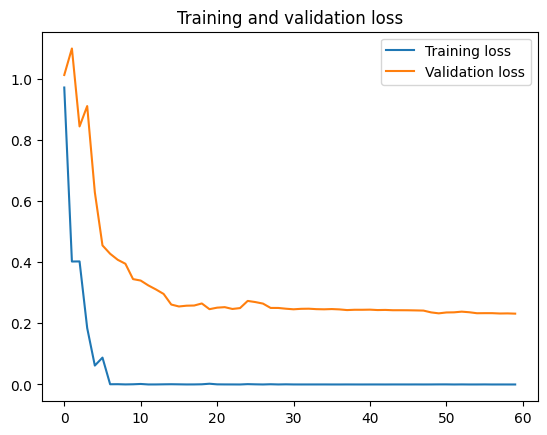

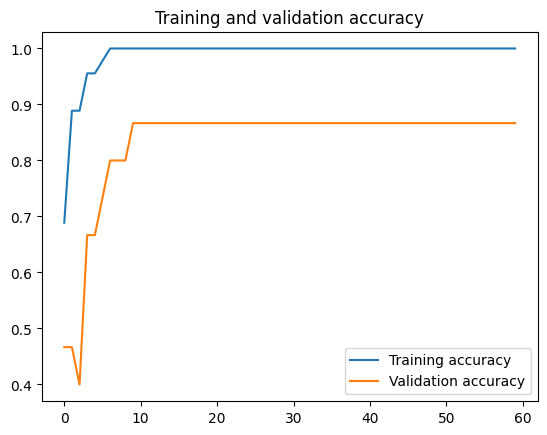

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 21, 56, 64)        58432     
                                                                 
 batch_normalization_33 (Bat  (None, 21, 56, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 21, 28, 64)       0         
 g2D)                                                            
                                                                 
 dropout_54 (Dropout)        (None, 21, 28, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 20, 27, 32)        8224      
                                                                 
 batch_normalization_34 (Bat  (None, 20, 27, 32)     

Epoch 1/60
45/45 - 8s - loss: 1.3845 - accuracy: 0.6222 - sen: 0.6222 - val_loss: 1.6215 - val_accuracy: 0.6000 - val_sen: 0.6000 - lr: 0.0010 - 8s/epoch - 174ms/step
Epoch 2/60
45/45 - 7s - loss: 0.6328 - accuracy: 0.8000 - sen: 0.8000 - val_loss: 1.6858 - val_accuracy: 0.4000 - val_sen: 0.4000 - lr: 0.0010 - 7s/epoch - 150ms/step
Epoch 3/60
45/45 - 7s - loss: 0.0109 - accuracy: 1.0000 - sen: 1.0000 - val_loss: 1.6863 - val_accuracy: 0.4000 - val_sen: 0.4000 - lr: 0.0010 - 7s/epoch - 149ms/step
Epoch 4/60
45/45 - 7s - loss: 0.0036 - accuracy: 1.0000 - sen: 1.0000 - val_loss: 1.5292 - val_accuracy: 0.4000 - val_sen: 0.4000 - lr: 0.0010 - 7s/epoch - 148ms/step
Epoch 5/60
45/45 - 7s - loss: 0.0010 - accuracy: 1.0000 - sen: 1.0000 - val_loss: 1.3841 - val_accuracy: 0.4000 - val_sen: 0.4000 - lr: 0.0010 - 7s/epoch - 149ms/step
Epoch 6/60
45/45 - 7s - loss: 0.0015 - accuracy: 1.0000 - sen: 1.0000 - val_loss: 1.2139 - val_accuracy: 0.5333 - val_sen: 0.5333 - lr: 0.0010 - 7s/epoch - 148ms/ste

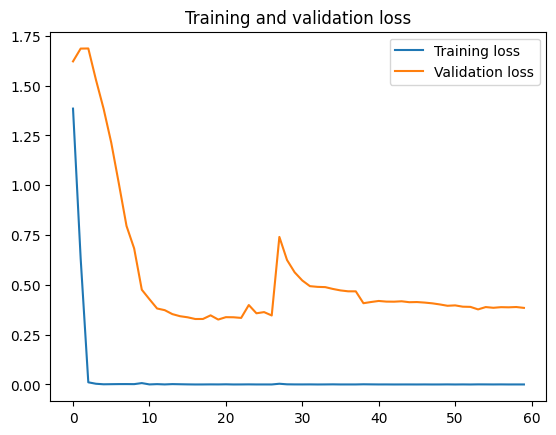

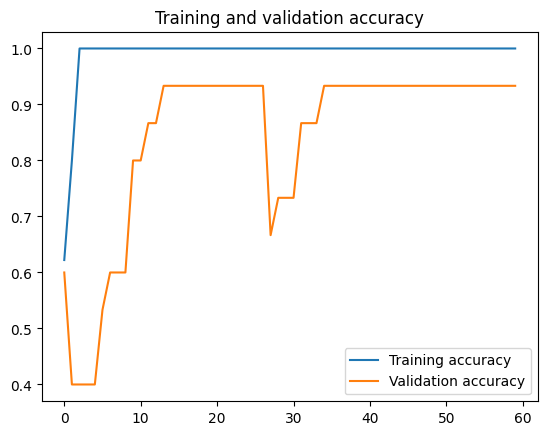

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 21, 56, 64)        58432     
                                                                 
 batch_normalization_36 (Bat  (None, 21, 56, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 21, 28, 64)       0         
 g2D)                                                            
                                                                 
 dropout_58 (Dropout)        (None, 21, 28, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 20, 27, 32)        8224      
                                                                 
 batch_normalization_37 (Bat  (None, 20, 27, 32)     

Epoch 1/60
45/45 - 7s - loss: 0.9881 - accuracy: 0.6667 - sen: 0.6667 - val_loss: 2.3915 - val_accuracy: 0.4667 - val_sen: 0.4667 - lr: 0.0010 - 7s/epoch - 162ms/step
Epoch 2/60
45/45 - 6s - loss: 0.2681 - accuracy: 0.9333 - sen: 0.9333 - val_loss: 0.4211 - val_accuracy: 0.7333 - val_sen: 0.7333 - lr: 0.0010 - 6s/epoch - 144ms/step
Epoch 3/60


In [39]:
print("START")
if not os.path.exists(OutputPathModels):
    os.makedirs(OutputPathModels)
print("Parameters loaded")

for indexPat in range(0, len(patients)):
    print('Patient '+patients[indexPat])
    if not os.path.exists(OutputPathModels+"ModelPat"+patients[indexPat]+"/"):
        os.makedirs(OutputPathModels+"ModelPat"+patients[indexPat]+"/")
    loadSpectogramData(indexPat) 
    print('Spectograms data loaded')
    
    result='Patient '+patients[indexPat]+'\n'     
    result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
    for i in range(0, nSeizure):
        print('SEIZURE OUT: '+str(i+1))
        
        print('Training start')  
        model = createModel()
        filesPath=getFilesPathWithoutSeizure(i, indexPat)

        initial_learning_rate = 0.001
        decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
        decay_rate = 0.1  # Tasso di decay
        lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)  
   
        history = model.fit(generate_arrays_for_training(indexPat, filesPath, end=75), #end=75),#It take the first 75%
                                validation_data=generate_arrays_for_training(indexPat, filesPath, start=75),#start=75), #It take the last 25%
                                #steps_per_epoch=10000, epochs=10)
                                steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))),#*25), 
                                validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))),#*75),
                                verbose=2,
                                epochs=60, max_queue_size=2, shuffle=True, callbacks=[LearningRateScheduler(lr_schedule)])# 100 epochs è meglio #aggiungere criterio di stop in base accuratezza
        
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        epochs = range(len(train_loss))

        plt.figure()
        plt.plot(epochs, train_loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.figure()
        plt.plot(epochs, train_acc, label='Training accuracy')
        plt.plot(epochs, val_acc, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.show()

        model.summary()
        
        print('Training end')
        
        print('Testing start')
        filesPath=interictalSpectograms[i]
        interPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        filesPath=preictalRealSpectograms[i]
        preictPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        print('Testing end')
        

        # Creates a HDF5 file 
        model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
        print("Model saved")
        
        #to plot the model
        #plot_model(model, to_file="CNNModel", show_shapes=True, show_layer_names=True)
        
        if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
            os.makedirs(OutputPathModels+"OutputTest"+"/")
        np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
        np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")

    with open(OutputPath, "a+") as myfile:
        myfile.write(result)

In [ ]:
secondsInterictalInTest=len(interictalSpectograms[i])*50*30#50 spectograms for file, 30 seconds for each spectogram
acc=0#accumulator
fp=0
tp=0
fn=0
lastTenResult=list()

for el in interPrediction:
    if(el[1]>0.5):
        acc=acc+1
        lastTenResult.append(1)
    else:
        lastTenResult.append(0)
    if(len(lastTenResult)>10):
        acc=acc-lastTenResult.pop(0)
    if(acc>=8):
        fp=fp+1
        lastTenResult=list()
        acc=0

lastTenResult=list()
for el in preictPrediction:
    if(el[1]>0.5):
        acc=acc+1
        lastTenResult.append(1)
    else:
        lastTenResult.append(0)
    if(len(lastTenResult)>10):
        acc=acc-lastTenResult.pop(0)
    if(acc>=8):
        tp=tp+1 
    else:
        if(len(lastTenResult)==10):
            fn=fn+1 
            
sensitivity=tp/(tp+fn)
FPR=fp/(secondsInterictalInTest/(60*60))

result=result+str(i+1)+','+str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','
result=result+str(sensitivity)+','+str(FPR)+'\n'
print('True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR')
print(str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','+str(sensitivity)+','+str(FPR))
with open(OutputPath, "a+") as myfile:
    myfile.write(result)
    

In [ ]:
patients=["01","02","03","09"]


for indexPat in range(0, len(patients)):
    
    loadSpectogramData(indexPat)
    result='Patient '+patients[indexPat]+'\n'     
    result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
    
    for i in range(0, nSeizure):

        model = load_model(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
        print('Testing start')
        filesPath=interictalSpectograms[i]
        interPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        filesPath=preictalRealSpectograms[i]
        preictPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        print('Testing end')

        secondsInterictalInTest=len(interictalSpectograms[i])*50*30#50 spectograms for file, 30 seconds for each spectogram
        tn=0
        fp=0
        tp=0
        fn=0
        
        for el in interPrediction:
            if(el[1]>0.5):
                tp = tp+1
            else:
                fn=fn+1
           
        for el in preictPrediction:
            if(el[1]>0.5):
                fp=fp+1
            else:
               tn=tn+1
                    
        sensitivity=tp/(tp+fn)
        FPR=fp/(secondsInterictalInTest/(60*60))
        
        result=result+str(i+1)+','+str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','
        result=result+str(sensitivity)+','+str(FPR)+'\n'
        print('True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR')
        print(str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','+str(sensitivity)+','+str(FPR))
        
    with open(OutputPath, "a+") as myfile:
        myfile.write(result)

START
Parameters loaded
Patient 01
Patient 02
Patient 03
Patient 05
Patient 09
(1240,)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_183 (Conv2D)         (None, 21, 56, 64)        58432     
                                                                 
 batch_normalization_183 (Ba  (None, 21, 56, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_183 (MaxPooli  (None, 21, 28, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_243 (Dropout)       (None, 21, 28, 64)        0         
                                                                 
 conv2d_184 (Conv2D)         (None, 20, 27, 32)        8224      
                                

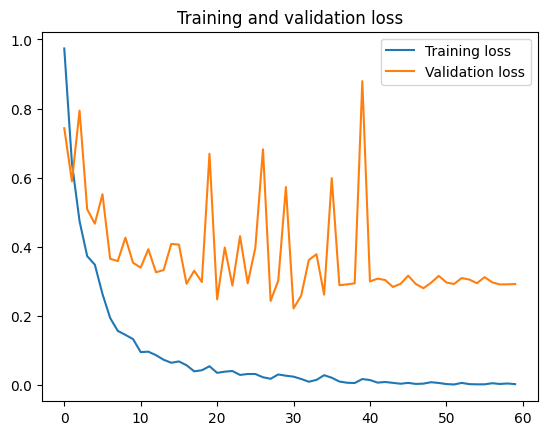

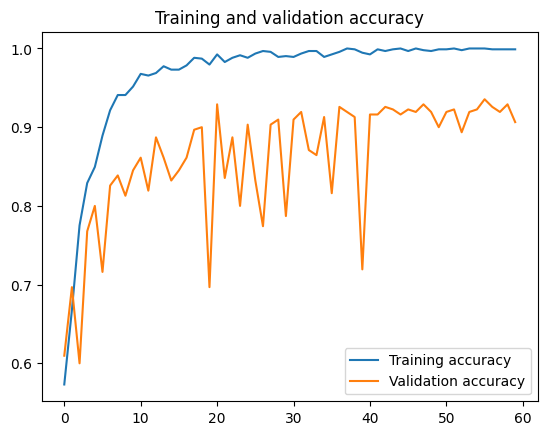

Training end


In [72]:
print("START")
if not os.path.exists(OutputPathModels):
    os.makedirs(OutputPathModels)
print("Parameters loaded")
nSeizure=0

for indexPat in range(0, len(patients)):
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat) 
       
result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
filesPath = getFilesPathWithoutSeizure(i)
print(np.shape(filesPath))
    
initial_learning_rate = 0.001
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

model = createModel()
model.summary()

history = model.fit(generate_arrays_for_training(filesPath, end=75), #end=75),#It take the first 75%
                        validation_data=generate_arrays_for_training(filesPath, start=75),#start=75), #It take the last 25%
                        #steps_per_epoch=10000, epochs=10)
                        steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))),#*25), 
                        validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))),#*75),
                        epochs=60, max_queue_size=2, shuffle=True, callbacks=[LearningRateScheduler(lr_schedule)])# 100 epochs è meglio #aggiungere criterio di stop in base accuratezza

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Creates a HDF5 file 
model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
print("Model saved")
        
epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

print('Training end')


In [41]:
print("START")
if not os.path.exists(OutputPathModels):
    os.makedirs(OutputPathModels)
print("Parameters loaded")
nSeizure=0

for indexPat in range(0, len(patients)):
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat) 
       
result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
filesPath = getFilesPathWithoutSeizure(i)
print(np.shape(filesPath))
    
initial_learning_rate = 0.001
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

model = createModel()
model.summary()

history = model.fit(generate_arrays_for_training(filesPath, end=75), #end=75),#It take the first 75%
                        validation_data=generate_arrays_for_training(filesPath, start=75),#start=75), #It take the last 25%
                        steps_per_epoch=500,
                        #steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))),#*25), 
                        validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))),#*75),
                        epochs=70, max_queue_size=3, shuffle=True, callbacks=[LearningRateScheduler(lr_schedule)])# 100 epochs è meglio #aggiungere criterio di stop in base accuratezza

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Creates a HDF5 file 
model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
print("Model saved")
        
epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

print('Training end')


START
Parameters loaded
Patient 01
Patient 02
Patient 03
Patient 05
Patient 09
(4960,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 21, 56, 64)        58432     
                                                                 
 batch_normalization_19 (Bat  (None, 21, 56, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 21, 28, 64)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 21, 28, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 27, 32)        8224      
                                 

In [8]:
model.save(OutputPathModels+"ModelPat.h5")
print("Model saved")

Model saved


In [11]:
for indexPat in range(0, len(patients)):
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat) 

Patient 01
Patient 02
Patient 03
Patient 05
Patient 09


In [ ]:
for indexPat in range(0, len(patients)):
    
    result='Patient '+patients[indexPat]+'\n'     
    result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
    
    for i in range(0, nSeizure):
        
        print('Testing start')
        filesPath=interictalSpectograms[i]
        interPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        filesPath=preictalRealSpectograms[i]
        preictPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        print('Testing end')
        
        #to plot the model
        #plot_model(model, to_file="CNNModel", show_shapes=True, show_layer_names=True)
        
        if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
            os.makedirs(OutputPathModels+"OutputTest"+"/")
        np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
        np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")
        
        secondsInterictalInTest=len(interictalSpectograms[i])*50*30#50 spectograms for file, 30 seconds for each spectogram
        acc=0#accumulator
        fp=0
        tp=0
        fn=0
        lastTenResult=list()
        
        for el in interPrediction:
            if(el[1]>0.5):
                acc=acc+1
                lastTenResult.append(1)
            else:
                lastTenResult.append(0)
            if(len(lastTenResult)>10):
                acc=acc-lastTenResult.pop(0)
            if(acc>=8):
                fp=fp+1
                lastTenResult=list()
                acc=0
        
        lastTenResult=list()
        for el in preictPrediction:
            if(el[1]>0.5):
                acc=acc+1
                lastTenResult.append(1)
            else:
                lastTenResult.append(0)
            if(len(lastTenResult)>10):
                acc=acc-lastTenResult.pop(0)
            if(acc>=8):
                tp=tp+1 
            else:
                if(len(lastTenResult)==10):
                    fn=fn+1 
                    
        if (tp+fn) != 0:
            sensitivity=tp/(tp+fn)
        else:
            sensitivity=0
        
        FPR=fp/(secondsInterictalInTest/(60*60))
        
        result=result+str(i+1)+','+str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','
        result=result+str(sensitivity)+','+str(FPR)+'\n'
        print('True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR')
        print(str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','+str(sensitivity)+','+str(FPR))
    with open(OutputPath, "a+") as myfile:
        myfile.write(result)


    if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
        os.makedirs(OutputPathModels+"OutputTest"+"/")
        np.savetxt("OutputTest"+"/"+"Int.csv", interPrediction, delimiter=",")
        np.savetxt("OutputTest"+"/"+"Pre.csv", preictPrediction, delimiter=",")

with open(OutputPath, "a+") as myfile:
    myfile.write(result)